# Time Series Analysis

In [1]:
# !pip install pmdarima

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
url = "https://raw.githubusercontent.com/Agablue-red/Machine-Learning/master/data/Dataset.csv"
df = pd.read_csv(url)

In [4]:
df.drop(columns=['symbol', 'sector'], inplace = True)

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
df['Year'] = df.Date.apply(lambda x: x.year)
df = df.set_index('Date')

In [6]:
data = df[(df.Year >= 2006)]

### Visualization of the stock’s weekly closing price and rate of return. 

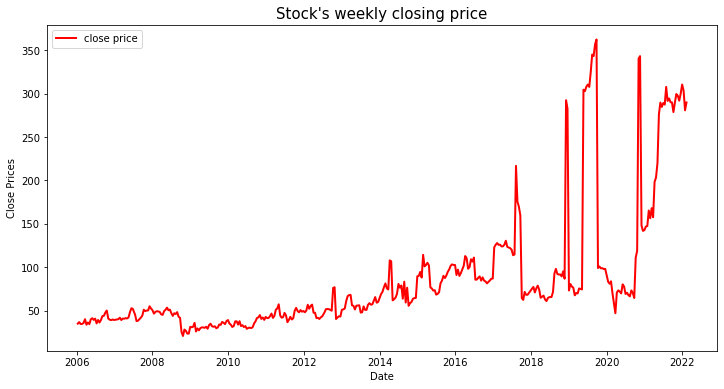

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = data.index, y = "close", data = data,
             ci = None,
             color = "red",
             linewidth = 2,
             label = 'close price')

plt.title("Stock's weekly closing price", fontsize = 15)
plt.ylabel('Close Prices')
plt.legend(loc = 'upper left')

The process above is not stationary, because the mean is not constant through time.

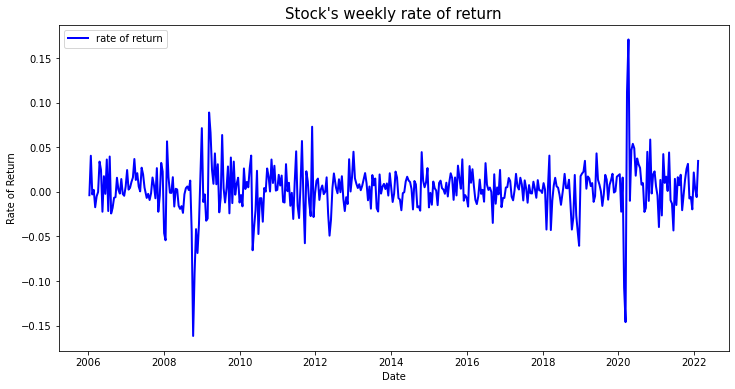

In [8]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = data.index, y = "return_rate", data = data,
             ci = None,
             color = "blue",
             linewidth = 2,
             label = 'rate of return')

plt.title("Stock's weekly rate of return", fontsize = 15)
plt.ylabel('Rate of Return')
plt.legend(loc = 'upper left')

The rate of return has many fluctuations, while the seasonality is not observed. The highest deviance was observed in 2008 with a weekly return of -17%. In 2020, the biggest fluctuations on rate of return were found out in between -14% and 17%.

### Rolling statistics

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

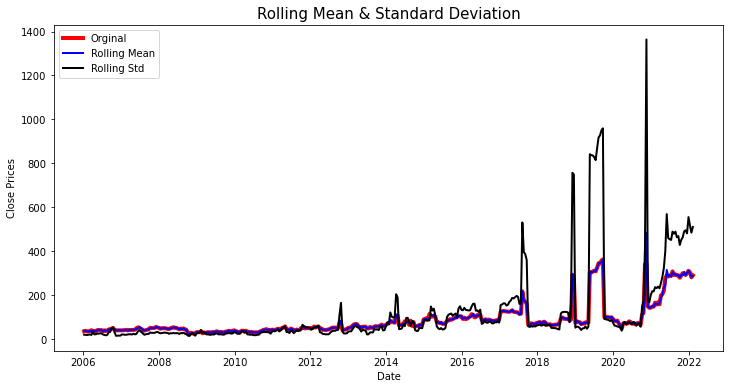

In [9]:
rolling_mean = data['close'].rolling(12).mean()
rolling_std = data['close'].rolling(12).std()

plt.figure(figsize=(12, 6))

sns.lineplot(x = data.index, y = "close", data = data,
             ci = None,
             color = "red",
             linewidth = 4,
             label = 'Orginal')

sns.lineplot(x = data.index, y = rolling_mean, data = data,
             ci = None,
             color = "blue",
             linewidth = 2,
             label = 'Rolling Mean')

sns.lineplot(x = data.index, y = rolling_std, data = data,
             ci = None,
             color = "black",
             linewidth = 2,
             label = 'Rolling Std')

plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.title("Rolling Mean & Standard Deviation", size=15)

The result of smoothing by the previous quarter can hardly see a trend, because it is too close to actual curve. In addition the increasing mean and standard deviation may be seen, indicating that our **series isn’t stationary**.

### Dickey-Fuller test

Dickey-Fuller test can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. 

This test’s null and alternate hypotheses are:
* Null Hypothesis: The series has a unit root (value of a =1)
* Alternate Hypothesis: The series has no unit root.

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

In [10]:
from statsmodels.tsa.stattools import adfuller

print('Results od Dickey-Fuller Test')
adft = adfuller(data['close'], autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']] , 
                          "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                    "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

Results od Dickey-Fuller Test
         Values                       Metric
0    -20.962812              Test Statistics
1      0.000000                      p-value
2     38.000000             No. of lags used
3  27883.000000  Number of observations used
4     -3.430585          critical value (1%)
5     -2.861644          critical value (5%)
6     -2.566825         critical value (10%)


We can rule out the Null hypothesis because the p-value is smaller than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is **nonlinear**.

###  Decomposing time series from the Trend and Seasonality.

<Figure size 432x288 with 0 Axes>

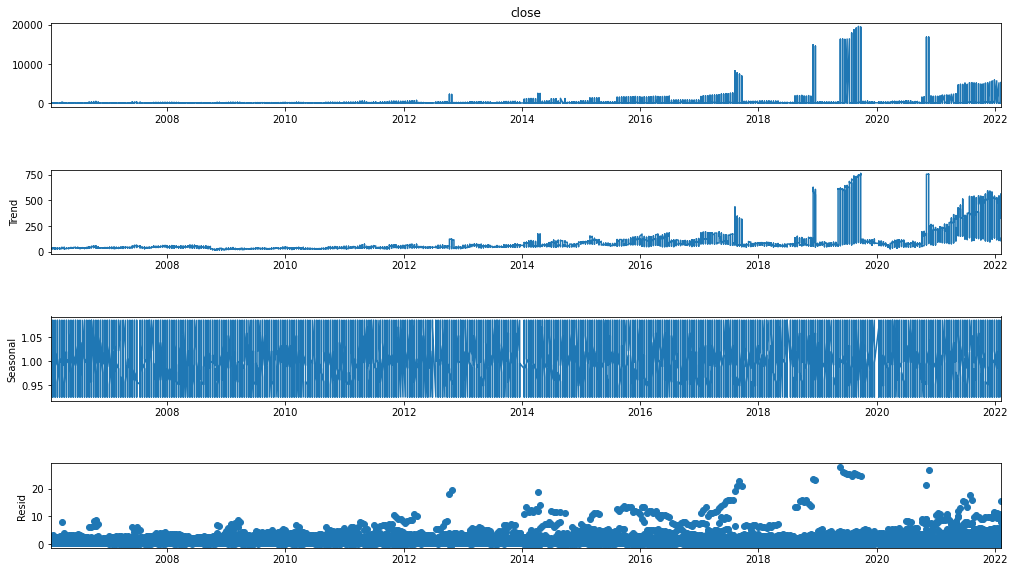

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(data['close'], model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Seasonal')

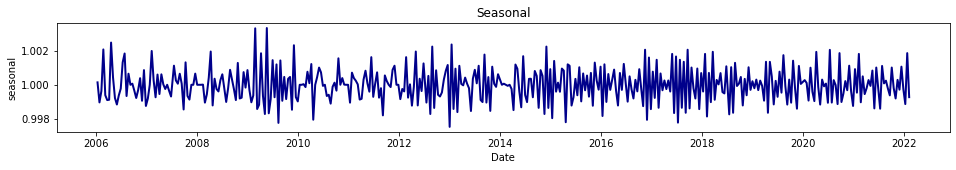

In [30]:
#seasonal

plt.subplots(figsize=(16, 2))
sns.lineplot(x = data.index, y = result.seasonal, data = data,
             ci = None,
             color = "darkblue",
             linewidth = 2)
plt.title("Seasonal", size=12)

The figure shows close price, trend, seasonality and residual distribution. We can see that the trend and seasonality don't exist. The residuals are also interesting, showing periods of high variability in from 2012 and later years of the series.

**Estimating trend**

The log of the series was used to reduce the magnitude of the values and the growing trend in the series.

Text(0.5, 1.0, 'Close Price using Log scale')

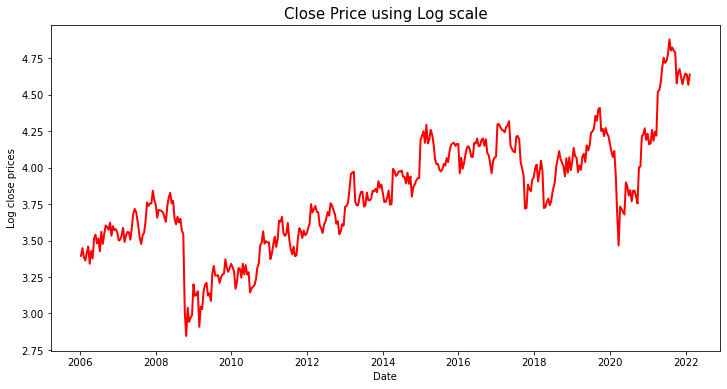

In [12]:
#eliminate trend

plt.subplots(figsize=(12, 6))

sns.lineplot(x = data.index, y = np.log(data['close']), data = data,
             ci = None,
             color = "red",
             linewidth = 2)

plt.ylabel('Log close prices')
plt.title("Close Price using Log scale", size=15)

Visualization of logarithmic closing prices. The falls are the results of crises. The trend is growing.

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation using Log scale')

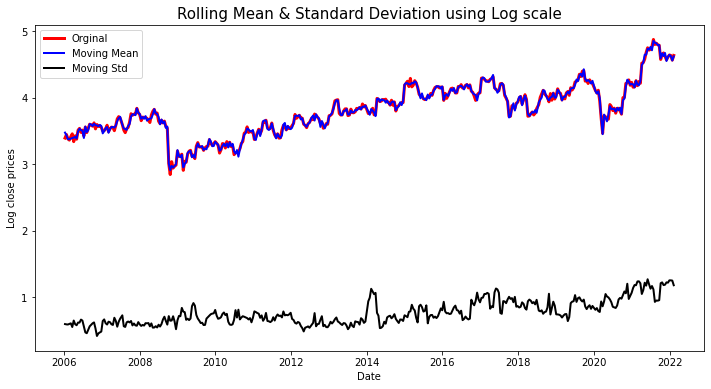

In [13]:
df_log = np.log(data['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

plt.subplots(figsize=(12, 6))

sns.lineplot(x = data.index, y = df_log, data = data,
             ci = None,
             color = "red",
             linewidth = 3,
             label = 'Orginal')

sns.lineplot(x = data.index, y = moving_avg, data = data,
             ci = None,
             color = "blue",
             linewidth = 2,
             label = 'Moving Mean')

sns.lineplot(x = data.index, y = std_dev, data = data,
             ci = None,
             color = "black",
             linewidth = 2,
             label = 'Moving Std')

plt.ylabel('Log close prices')
plt.title("Rolling Mean & Standard Deviation using Log scale", size=15)

As in the previous chart for rolling statistics, there is nonlinear.

### ARIMA model

In [14]:
train_data = df_log['2010':'2020']
test_data = df_log['2021':'2022']

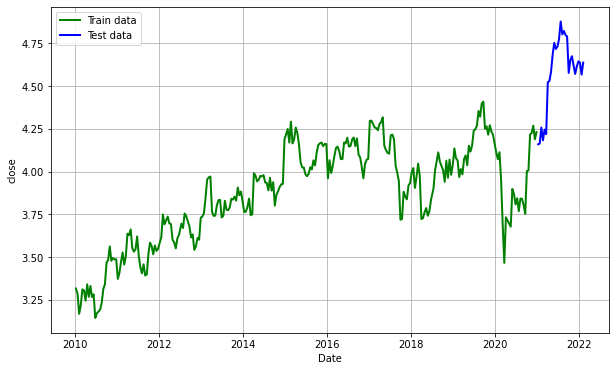

In [15]:
plt.figure(figsize=(10,6))
plt.grid(True)
sns.lineplot(x = train_data.index, y = train_data, data = train_data,
             ci = None,
             color = "green",
             linewidth = 2,
             label = 'Train data')

sns.lineplot(x = test_data.index, y = test_data, data = test_data,
             ci = None,
             color = "blue",
             linewidth = 2,
             label = 'Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=110992.473, Time=0.32 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=63183.521, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=93618.016, Time=0.95 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=57716.091, Time=0.46 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=7.61 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=6.41 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=11.68 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=51556.175, Time=1.78 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=51724.831, Time=0.94 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=51414.581, Time=1.78 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=51001.423, Time=34.00 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=51010.851, Time=22.55 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=50719.531, Time=31.79 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : 

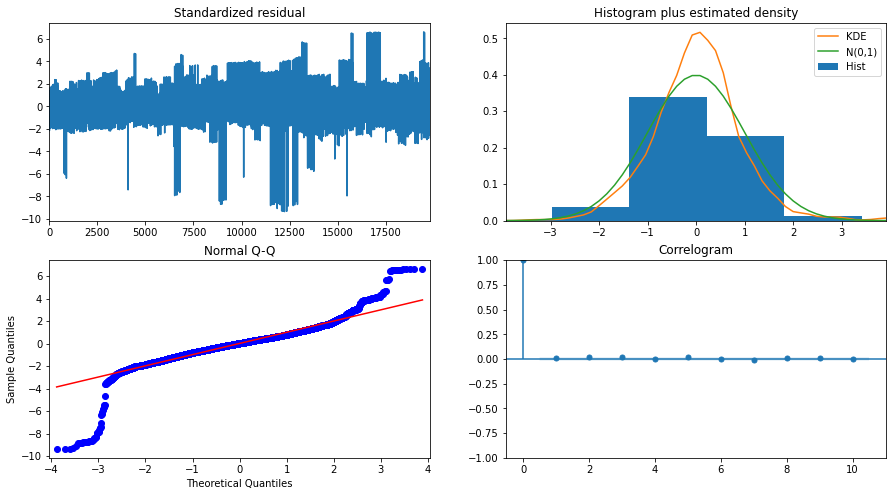

In [16]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, max_q=3, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0, 
                             D=0, 
                             trace=True,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Standardized residual**

The first chart shows the grouping of volatility. The residual errors appear to have a uniform variance and fluctuate between -2 and 2.

**Histogram plus estimated density**

The density plot suggests a normal distribution with a mean of zero which is the excess kurtosis with long tails.

**Normal Q-Q**

Normal Q-Q shows deviations from the red line, both at the beginning and at the end, which would indicate a skewed distribution with long tails.

**Correlogram**

The fourth graph shows the linear relationships in the first lag. As a result, more Xs (predictors) have to be added to the model.


In [17]:
print(model_autoARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                19797
Model:               SARIMAX(3, 0, 3)   Log Likelihood              -25160.959
Date:                Mon, 18 Apr 2022   AIC                          50337.918
Time:                        23:41:50   BIC                          50401.065
Sample:                             0   HQIC                         50358.588
                              - 19797                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0696      0.014      4.822      0.000       0.041       0.098
ar.L1         -0.9124      0.050    -18.208      0.000      -1.011      -0.814
ar.L2          0.9749      0.005    204.353      0.0

**SARIMAX(3, 0, 3)**

The best model with the lowest AIC = 50337.918 was selected.

Is each coefficient statistically significant?

The tests are:
* Null Hypothesis: each coefficient is NOT statistically significant. 
* Alternate Hypothesis: the coefficient is statistically significant (p-value of less than 0.05). 

**Each parameter is statistically significant.**

Are the residuals independent (white noise)?

The Ljung Box tests if the errors are white noise.

The probability (0.23) is above 0.05, so **we can’t reject the null that the errors are white noise**.

Do residuals show variance?

Heteroscedasticity tests if the error residuals are homoscedastic or have the same variance.

Test statistic is 1.82 while p-value of 0.00, which means that we can reject the null hypothesis and the **residuals show variance**.

Is data normally distributed?

Jarque-Bera test verifies the normality of the errors.

Test statistic of 104150.24 with a probability of 0, which means we reject the null hypothesis, and **the data is not normally distributed**. 

In addition results show:

* Negative skewness - left side asymmetry (long tail on the left side).
* Excess kurtosis - results fluctuate around a mean